By Afifa Tariq

Import Libraries


In [ ]:
import numpy as np
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import json
import shutil
import torchvision.datasets as dset
import matplotlib.pyplot as plt
from google.colab import files
from skimage.transform import resize
from skimage.util import crop
from skimage.color import rgb2gray
from skimage.util import pad
from skimage import io
import cv2
from skimage.feature import hog

Download and Extract dataset from Kaggle


In [ ]:
!mkdir .kaggle

token = {"username":"","key":""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d xainano/handwrittenmathsymbols -p /content  
!unzip \*.zip
get_ipython().system_raw("unrar x data")
!ls extracted_images

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
- path is now set to: {/content}
 97% 253M/262M [00:03<00:00, 79.6MB/s]
100% 262M/262M [00:03<00:00, 76.5MB/s]
Archive:  handwrittenmathsymbols.zip
  inflating: data.rar                
'='   +   9	      div	      H        leq   phi	  sqrt	  y
 -    0   A	      e		      i        lim   pi		  sum	  z
 ,    1   alpha       exists	      in       log   pm		  T
'!'   2   ascii_124   f		      infty    lt    prime	  tan
'('   3   b	      forall	      int      M     q		  theta
')'   4   beta	      forward_slash   j

Delete the extra folders from the dataset


In [ ]:
try:
    shutil.rmtree('extracted_images/A')
    shutil.rmtree('extracted_images/alpha')
    shutil.rmtree('extracted_images/ascii_124')
    shutil.rmtree('extracted_images/b')
    shutil.rmtree('extracted_images/beta')
    shutil.rmtree('extracted_images/C')
    shutil.rmtree('extracted_images/cos')
    shutil.rmtree('extracted_images/d')
    shutil.rmtree('extracted_images/Delta')

    shutil.rmtree('extracted_images/e')
    shutil.rmtree('extracted_images/exists')
    shutil.rmtree('extracted_images/f')
    shutil.rmtree('extracted_images/forall')
    shutil.rmtree('extracted_images/G')
    shutil.rmtree('extracted_images/gamma')
    shutil.rmtree('extracted_images/geq')
    shutil.rmtree('extracted_images/gt')

    shutil.rmtree('extracted_images/H')
    shutil.rmtree('extracted_images/i')
    shutil.rmtree('extracted_images/in')
    shutil.rmtree('extracted_images/infty')
    shutil.rmtree('extracted_images/int')
    shutil.rmtree('extracted_images/j')
    shutil.rmtree('extracted_images/k')
    shutil.rmtree('extracted_images/l')
    shutil.rmtree('extracted_images/lambda')
    shutil.rmtree('extracted_images/ldots')

    shutil.rmtree('extracted_images/leq')
    shutil.rmtree('extracted_images/lim')
    shutil.rmtree('extracted_images/log')
    shutil.rmtree('extracted_images/lt')
    shutil.rmtree('extracted_images/M')
    shutil.rmtree('extracted_images/mu')
    shutil.rmtree('extracted_images/N')
    shutil.rmtree('extracted_images/neq')
    shutil.rmtree('extracted_images/o')
    shutil.rmtree('extracted_images/p')

    shutil.rmtree('extracted_images/pi')
    
    shutil.rmtree('extracted_images/phi')
    shutil.rmtree('extracted_images/tan')
    shutil.rmtree('extracted_images/theta')
    shutil.rmtree('extracted_images/sqrt')
    shutil.rmtree('extracted_images/sin')
    shutil.rmtree('extracted_images/T')
    shutil.rmtree('extracted_images/sigma')
    shutil.rmtree('extracted_images/S')
    shutil.rmtree('extracted_images/rightarrow')
    shutil.rmtree('extracted_images/q')
    shutil.rmtree('extracted_images/R')
    shutil.rmtree('extracted_images/prime')
    shutil.rmtree('extracted_images/pm')
    shutil.rmtree('extracted_images/u')
    shutil.rmtree('extracted_images/v')
    shutil.rmtree('extracted_images/w')
    shutil.rmtree('extracted_images/X')
    shutil.rmtree('extracted_images/y')
    shutil.rmtree('extracted_images/z')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
  
!ls extracted_images/

'='   ,   '('  '['  '{'   +   1   3   5   7   9     forward_slash   times
 -   '!'  ')'   ]   '}'   0   2   4   6   8   div   sum


Install split folders library to divide the data into training and test set

In [ ]:
!pip install split_folders    # Library to split Train and valid Image sets in ImageNet style
import split_folders
split_folders.ratio('extracted_images', output="final_output_images", ratio=(.8, .2)) # default va

Copying files: 207643 files [00:39, 5229.83 files/s]


Apply transformations to the images and then add to a data loader

In [ ]:
datarootTrain = 'final_output_images/train'
datarootVal = 'final_output_images/val'
image_size = 28

trainset = dset.ImageFolder(root=datarootTrain,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

valset = dset.ImageFolder(root=datarootVal,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Plot some of the images from the dataset

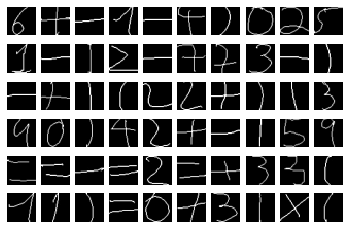

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Define Network model

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 25

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=25, bias=True)
  (5): LogSoftmax()
)


Define loss function

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.9941e-04, -3.9941e-04, -3.9941e-04,  ..., -3.9941e-04,
         -3.9941e-04, -3.9941e-04],
        ...,
        [-2.4809e-05, -2.7514e-05, -2.4809e-05,  ..., -2.7514e-05,
         -2.7514e-05, -2.7514e-05],
        [-5.1169e-03, -5.1191e-03, -5.1142e-03,  ..., -5.7786e-03,
         -5.6301e-03, -5.3296e-03],
        [ 3.6836e-04,  2.6107e-04,  3.2981e-04,  ...,  1.3636e-04,
          1.6042e-04,  3.2753e-04]])


## Training

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
losses = []
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()

        # Save Losses for plotting later
        losses.append(running_loss/len(trainloader))
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.2382554520489806
Epoch 1 - Training loss: 0.4873535946120604
Epoch 2 - Training loss: 0.35678625765768884
Epoch 3 - Training loss: 0.29166257163460935
Epoch 4 - Training loss: 0.2522386996927908
Epoch 5 - Training loss: 0.22521787385337158
Epoch 6 - Training loss: 0.20394018680884723
Epoch 7 - Training loss: 0.1887702710814602
Epoch 8 - Training loss: 0.17280320517032857
Epoch 9 - Training loss: 0.16197017218217322
Epoch 10 - Training loss: 0.15086917944061634
Epoch 11 - Training loss: 0.14362579099733513
Epoch 12 - Training loss: 0.13523148364231036
Epoch 13 - Training loss: 0.1275022552199432
Epoch 14 - Training loss: 0.12319076807885351

Training Time (in minutes) = 20.316824471950532


Plot Loss curve

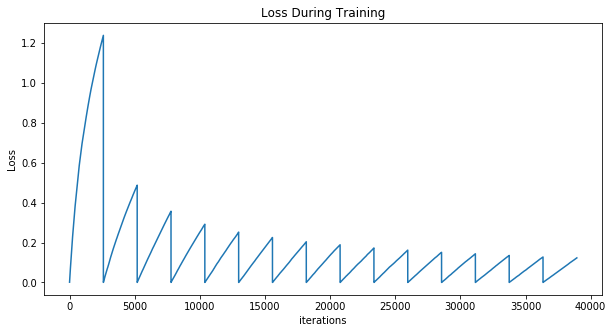

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

Create funtion to view the image and predicted result

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(25), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(25))
    ax2.set_yticklabels(np.arange(25))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predict digit for one example from test set

torch.Size([1, 28, 28])
torch.Size([1, 784])
Predicted Digit = 5
5
5


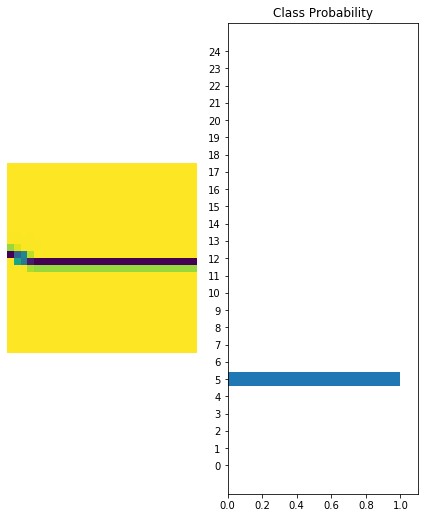

In [ ]:
images, labels = next(iter(valloader))
print(images[0].shape)
img = images[0].view(1, 784)
print(img.shape)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

pred_label = probab.index(max(probab))
true_label = labels.numpy()[0]

Check predicted and true value for all test images to calculate accuracy.

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 41538

Model Accuracy = 0.961769945591988


Upload file to guess values in math equation

In [ ]:
uploaded = files.upload()
img_file = ""
for fn in uploaded.keys():
  img_file = fn
  print(fn)
  
temp = io.imread(img_file)


Saving test1.png to test1.png
test1.png


Functions to detect the different digits and symbols in image.

loading "test1.png for digit recognition" ...


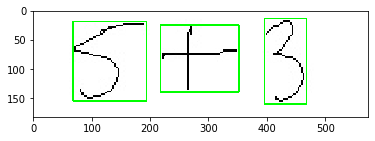

In [ ]:
def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]   
    final_bounding_rectangles = []
    #find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:,-1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]
    
    for r,hr in zip(bounding_rectangles, hierarchy):
        x,y,w,h = r
        if ((w*h)>250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy: 
            final_bounding_rectangles.append(r)    

    return final_bounding_rectangles

def proc_user_img(img_file):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)    
    blank_image = np.zeros((im.shape[0],im.shape[1],3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5,5),np.uint8)
    
    ret,thresh = cv2.threshold(imgray,127,255,0)   
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    digits_rectangles = get_digits(contours,hierarchy)  #rectangles of bounding the digits in user image
    for rect in digits_rectangles:
        x,y,w,h = rect
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png",im) 
    cv2.imwrite("final_digits.png",blank_image) 
    cv2.destroyAllWindows()  
    
    return digits_rectangles    
    
    
digit_rectangles = proc_user_img(img_file)

For each rectangle predict digit

(218, 25, 134, 114)
Predicted Digit = 5
(68, 19, 126, 135)
Predicted Digit = 4
(396, 14, 72, 145)
Predicted Digit = 7


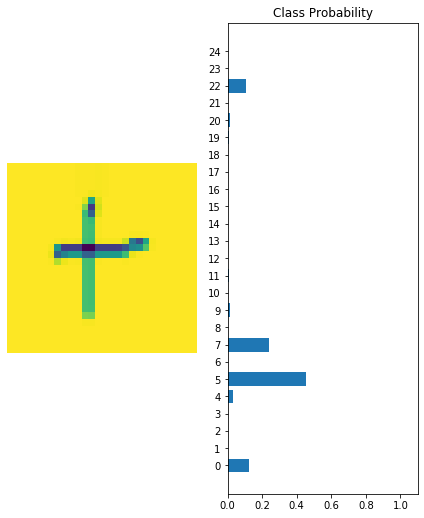

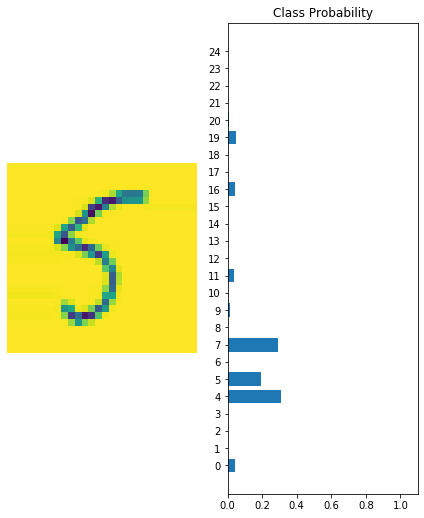

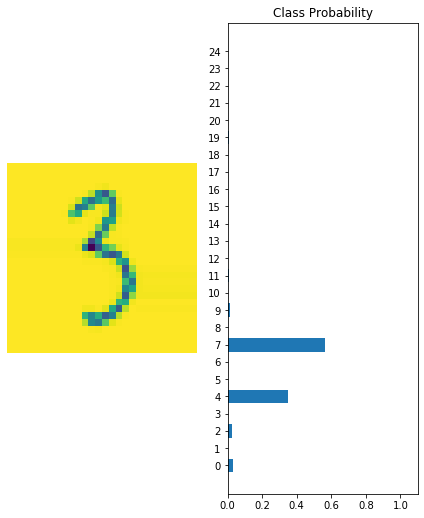

In [ ]:
for rect in digit_rectangles:
  x,y,w,h = rect
  print(rect)
  temp = rgb2gray(temp)
  cropped = temp[y:(y+h), x:(x+w)]
  cropped = pad(cropped, ((30,30),(70,70)), 'edge')
  image_resized = resize(cropped, (28,28), anti_aliasing=True)
  image_resized = rgb2gray(image_resized)
  input_img =torch.tensor(image_resized).float()
  input_img = input_img.unsqueeze(0)

  img = input_img.view(1, 784)
  with torch.no_grad():
      logps = model(img)

  ps = torch.exp(logps)
  probab = list(ps.numpy()[0])
  print("Predicted Digit =", probab.index(max(probab)))
  view_classify(img.view(1, 28, 28), ps)